# VideoMAE 8-Frame: Single Checkpoint Resume

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
logging.getLogger('transformers').setLevel(logging.ERROR)

In [2]:
!pip install -q transformers accelerate

In [3]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from transformers import VideoMAEForVideoClassification, VideoMAEImageProcessor
from transformers import get_cosine_schedule_with_warmup
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
import numpy as np
import random
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import gc

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

PATH_DATA_TRAIN = '/kaggle/input/action-video/data/data_train'
PATH_DATA_TEST = '/kaggle/input/action-video/data/test'

E0000 00:00:1768754346.399935   15154 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768754346.406685   15154 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Device: cuda


In [4]:
!gdown "1Xv2CWOqdBj3kt0rkNJKRsodSIEd3-wX_" -O test_labels.csv -q
gt_df = pd.read_csv("test_labels.csv")
TEST_LABELS = dict(zip(gt_df['id'].astype(str), gt_df['class']))
del gt_df; gc.collect()
print(f"Test labels: {len(TEST_LABELS)}")

Test labels: 510


## 1. Config

In [5]:
MODEL_CKPT = "MCG-NJU/videomae-base-finetuned-kinetics"
NUM_FRAMES = 8
IMG_SIZE = 224
RESIZE_SIZE = 256

EPOCHS_P1 = 50
EPOCHS_P2 = 10
LR_P1 = 5e-5
LR_P2 = 1e-6
LABEL_SMOOTHING = 0.1

BATCH_SIZE = 42
NUM_WORKERS = 4
WEIGHT_DECAY = 0.05
MIXUP_ALPHA = 0.8

print(f"LR_P1={LR_P1}, LR_P2={LR_P2}, BATCH={BATCH_SIZE}, WORKERS={NUM_WORKERS}")

LR_P1=5e-05, LR_P2=1e-06, BATCH=42, WORKERS=4


## 2. Dataset

In [6]:
image_processor = VideoMAEImageProcessor.from_pretrained(MODEL_CKPT)
MEAN, STD = image_processor.image_mean, image_processor.image_std

class MixupCollate:
    def __init__(self, num_classes, alpha=0.8):
        self.num_classes, self.alpha = num_classes, alpha
    def __call__(self, batch):
        inputs, targets = torch.utils.data.default_collate(batch)
        lam = np.random.beta(self.alpha, self.alpha)
        idx = torch.randperm(inputs.size(0))
        inputs = lam * inputs + (1 - lam) * inputs[idx]
        oh = F.one_hot(targets, self.num_classes).float()
        return inputs, lam * oh + (1 - lam) * oh[idx]

class VideoDataset(Dataset):
    def __init__(self, root, num_frames=8, is_train=True):
        self.root, self.num_frames, self.is_train = Path(root), num_frames, is_train
        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.samples = [(list(sorted(v.glob('*.jpg'))), self.class_to_idx[c]) 
                        for c in self.classes for v in (self.root/c).iterdir() if v.is_dir()]
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        paths, label = self.samples[idx]
        indices = np.linspace(0, len(paths)-1, self.num_frames, dtype=int)
        frames = [TF.resize(Image.open(paths[i]).convert('RGB'), RESIZE_SIZE) for i in indices]
        if self.is_train:
            i,j,h,w = T.RandomResizedCrop.get_params(frames[0], (0.8,1.0), (0.75,1.33))
            flip = random.random() > 0.5
            frames = [TF.normalize(TF.to_tensor(TF.hflip(TF.resized_crop(f,i,j,h,w,(IMG_SIZE,IMG_SIZE))) if flip else TF.resized_crop(f,i,j,h,w,(IMG_SIZE,IMG_SIZE))), MEAN, STD) for f in frames]
        else:
            frames = [TF.normalize(TF.to_tensor(TF.center_crop(f, IMG_SIZE)), MEAN, STD) for f in frames]
        return torch.stack(frames), label

class TestDataset(Dataset):
    def __init__(self, root, num_frames=8):
        self.root, self.num_frames = Path(root), num_frames
        self.videos = sorted([d for d in self.root.iterdir() if d.is_dir()], key=lambda x: int(x.name))
    def __len__(self): return len(self.videos)
    def __getitem__(self, idx):
        v = self.videos[idx]
        paths = sorted(v.glob('*.jpg'))
        indices = np.linspace(0, len(paths)-1, self.num_frames, dtype=int)
        frames = [TF.normalize(TF.to_tensor(TF.center_crop(TF.resize(Image.open(paths[i]).convert('RGB'), RESIZE_SIZE), IMG_SIZE)), MEAN, STD) for i in indices]
        return torch.stack(frames), int(v.name)

In [7]:
train_dataset = VideoDataset(PATH_DATA_TRAIN, NUM_FRAMES, is_train=True)
test_dataset = TestDataset(PATH_DATA_TEST, NUM_FRAMES)
print(f"Train: {len(train_dataset)} | Test: {len(test_dataset)} | Classes: {len(train_dataset.classes)}")

mixup_collate = MixupCollate(len(train_dataset.classes), MIXUP_ALPHA)
train_loader_p1 = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, collate_fn=mixup_collate, drop_last=True)
train_loader_p2 = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

Train: 6254 | Test: 510 | Classes: 51


## 3. Model

In [8]:
model = VideoMAEForVideoClassification.from_pretrained(
    MODEL_CKPT, num_labels=len(train_dataset.classes), 
    ignore_mismatched_sizes=True, num_frames=NUM_FRAMES
).to(DEVICE)
print(f"Params: {sum(p.numel() for p in model.parameters()):,}")

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([51]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([51, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Params: 86,266,419


## 4. Training Functions

In [9]:
def train_epoch(model, loader, optimizer, scheduler, scaler, use_mixup=True, label_smoothing=0.0):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    
    for x, y in tqdm(loader, desc="Train", leave=False):
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        
        with torch.amp.autocast('cuda'):
            logits = model(x).logits
            if use_mixup:
                loss = -torch.sum(y * F.log_softmax(logits, 1), 1).mean()
                labels = y.argmax(1)
            else:
                loss = F.cross_entropy(logits, y, label_smoothing=label_smoothing)
                labels = y
        
        total_loss += loss.item()
        correct += (logits.argmax(1) == labels).sum().item()
        total += x.size(0)
        
        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        del x, y, logits, loss
    
    return total_loss / len(loader), correct / total

@torch.no_grad()
def evaluate(model, loader, classes):
    model.eval()
    all_preds, all_ids = [], []
    
    for x, ids in tqdm(loader, desc="Eval", leave=False):
        x = x.to(DEVICE, non_blocking=True)
        preds = model(x).logits.argmax(1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_ids.extend(ids.numpy().tolist())
        del x, preds
    
    y_pred = [classes[p] for vid, p in zip(all_ids, all_preds) if str(vid) in TEST_LABELS]
    y_true = [TEST_LABELS[str(vid)] for vid in all_ids if str(vid) in TEST_LABELS]
    return accuracy_score(y_true, y_pred)

def save_checkpoint(epoch, phase, loss, train_acc, test_acc, best_acc):
    """Save single checkpoint (overwrite) + append to CSV"""
    # Save model (overwrite)
    torch.save(model.state_dict(), 'checkpoint.pt')
    
    # Append to CSV
    row = {'epoch': epoch, 'phase': phase, 'loss': loss, 'train_acc': train_acc, 'test_acc': test_acc, 'best_acc': best_acc}
    df = pd.DataFrame([row])
    if os.path.exists('history.csv'):
        df.to_csv('history.csv', mode='a', header=False, index=False)
    else:
        df.to_csv('history.csv', index=False)
    
    print(f"  Loss:{loss:.4f} | Train:{train_acc:.4f} | Test:{test_acc:.4f} | Best:{best_acc:.4f}")

## 5. Check Resume

In [10]:
START_EPOCH = 1
START_PHASE = 'P1'
best_acc = 0

if os.path.exists('history.csv') and os.path.exists('checkpoint.pt'):
    df = pd.read_csv('history.csv')
    last = df.iloc[-1]
    
    model.load_state_dict(torch.load('checkpoint.pt', map_location=DEVICE))
    
    last_epoch = int(last['epoch'])
    START_PHASE = last['phase']
    best_acc = float(last['best_acc'])
    
    if START_PHASE == 'P1':
        START_EPOCH = last_epoch + 1
    else:  # P2
        START_EPOCH = last_epoch - EPOCHS_P1 + 1
    
    print(f"✅ Resume: epoch {last_epoch+1}, phase {START_PHASE}, best={best_acc:.4f}")
else:
    print("📝 Starting fresh")

✅ Resume: epoch 9, phase P1, best=0.8000


## 6. Phase 1: Mixup

In [11]:
if START_PHASE == 'P1' and START_EPOCH <= EPOCHS_P1:
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR_P1, weight_decay=WEIGHT_DECAY)
    total_steps = len(train_loader_p1) * EPOCHS_P1
    scheduler = get_cosine_schedule_with_warmup(optimizer, int(total_steps*0.1), total_steps)
    
    # Fast-forward scheduler
    for _ in range((START_EPOCH - 1) * len(train_loader_p1)):
        scheduler.step()
    
    scaler = torch.amp.GradScaler()
    
    print("="*60)
    print(f"PHASE 1: Mixup | LR={LR_P1} | Epochs {START_EPOCH}-{EPOCHS_P1}")
    print("="*60)
    
    for ep in range(START_EPOCH, EPOCHS_P1 + 1):
        print(f"\nEpoch {ep}/{EPOCHS_P1}")
        loss, train_acc = train_epoch(model, train_loader_p1, optimizer, scheduler, scaler, use_mixup=True)
        test_acc = evaluate(model, test_loader, train_dataset.classes)
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({'model': model.state_dict(), 'classes': train_dataset.classes}, 'best.pt')
            print(f"  >>> New Best!")
        
        save_checkpoint(ep, 'P1', loss, train_acc, test_acc, best_acc)
        gc.collect(); torch.cuda.empty_cache()
    
    print(f"\nP1 Done! Best: {best_acc:.4f}")
    START_EPOCH = 1
    START_PHASE = 'P2'
else:
    print(f"Skipping P1")

PHASE 1: Mixup | LR=5e-05 | Epochs 9-50

Epoch 9/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:0.9911 | Train:0.8560 | Test:0.8059 | Best:0.8059

Epoch 10/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:0.9647 | Train:0.8507 | Test:0.8196 | Best:0.8196

Epoch 11/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.9362 | Train:0.8552 | Test:0.8098 | Best:0.8196

Epoch 12/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.8930 | Train:0.8850 | Test:0.7941 | Best:0.8196

Epoch 13/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:0.9030 | Train:0.8509 | Test:0.8255 | Best:0.8255

Epoch 14/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:0.9076 | Train:0.8649 | Test:0.8294 | Best:0.8294

Epoch 15/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.8878 | Train:0.8452 | Test:0.8078 | Best:0.8294

Epoch 16/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.8376 | Train:0.8716 | Test:0.8235 | Best:0.8294

Epoch 17/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.8111 | Train:0.8779 | Test:0.8294 | Best:0.8294

Epoch 18/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:0.8221 | Train:0.8399 | Test:0.8314 | Best:0.8314

Epoch 19/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.8412 | Train:0.8697 | Test:0.8235 | Best:0.8314

Epoch 20/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7775 | Train:0.8764 | Test:0.8176 | Best:0.8314

Epoch 21/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7318 | Train:0.8935 | Test:0.8196 | Best:0.8314

Epoch 22/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7637 | Train:0.8818 | Test:0.8216 | Best:0.8314

Epoch 23/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7127 | Train:0.8888 | Test:0.8118 | Best:0.8314

Epoch 24/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7720 | Train:0.8620 | Test:0.8235 | Best:0.8314

Epoch 25/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7200 | Train:0.8945 | Test:0.8176 | Best:0.8314

Epoch 26/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7755 | Train:0.8734 | Test:0.8255 | Best:0.8314

Epoch 27/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7301 | Train:0.8853 | Test:0.8216 | Best:0.8314

Epoch 28/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7042 | Train:0.8801 | Test:0.8314 | Best:0.8314

Epoch 29/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.6693 | Train:0.8866 | Test:0.8294 | Best:0.8314

Epoch 30/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:0.6669 | Train:0.9070 | Test:0.8373 | Best:0.8373

Epoch 31/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7213 | Train:0.8747 | Test:0.8353 | Best:0.8373

Epoch 32/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.6444 | Train:0.8990 | Test:0.8255 | Best:0.8373

Epoch 33/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:0.6601 | Train:0.9015 | Test:0.8392 | Best:0.8392

Epoch 34/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.6544 | Train:0.9101 | Test:0.8275 | Best:0.8392

Epoch 35/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  >>> New Best!
  Loss:0.6647 | Train:0.9007 | Test:0.8412 | Best:0.8412

Epoch 36/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.6795 | Train:0.8909 | Test:0.8275 | Best:0.8412

Epoch 37/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.6370 | Train:0.8961 | Test:0.8275 | Best:0.8412

Epoch 38/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.6071 | Train:0.8922 | Test:0.8294 | Best:0.8412

Epoch 39/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.6391 | Train:0.8978 | Test:0.8353 | Best:0.8412

Epoch 40/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.6452 | Train:0.9028 | Test:0.8294 | Best:0.8412

Epoch 41/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.6506 | Train:0.8887 | Test:0.8216 | Best:0.8412

Epoch 42/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.6204 | Train:0.9080 | Test:0.8294 | Best:0.8412

Epoch 43/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.6118 | Train:0.9160 | Test:0.8255 | Best:0.8412

Epoch 44/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.6267 | Train:0.9118 | Test:0.8294 | Best:0.8412

Epoch 45/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.5858 | Train:0.9011 | Test:0.8235 | Best:0.8412

Epoch 46/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.6501 | Train:0.8879 | Test:0.8255 | Best:0.8412

Epoch 47/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.6061 | Train:0.9143 | Test:0.8255 | Best:0.8412

Epoch 48/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.6036 | Train:0.9041 | Test:0.8216 | Best:0.8412

Epoch 49/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.6166 | Train:0.9088 | Test:0.8196 | Best:0.8412

Epoch 50/50


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.6239 | Train:0.9168 | Test:0.8196 | Best:0.8412

P1 Done! Best: 0.8412


## 7. Phase 2: Label Smoothing

In [12]:
if START_PHASE == 'P2':
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR_P2, weight_decay=WEIGHT_DECAY)
    total_steps = len(train_loader_p2) * EPOCHS_P2
    scheduler = get_cosine_schedule_with_warmup(optimizer, 0, total_steps)
    
    p2_start = START_EPOCH if START_EPOCH > 1 else 1
    for _ in range((p2_start - 1) * len(train_loader_p2)):
        scheduler.step()
    
    scaler = torch.amp.GradScaler()
    
    print("\n" + "="*60)
    print(f"PHASE 2: Label Smoothing | LR={LR_P2} | Epochs {p2_start}-{EPOCHS_P2}")
    print("="*60)
    
    for ep in range(p2_start, EPOCHS_P2 + 1):
        global_ep = EPOCHS_P1 + ep
        print(f"\nEpoch {global_ep}/{EPOCHS_P1+EPOCHS_P2}")
        loss, train_acc = train_epoch(model, train_loader_p2, optimizer, scheduler, scaler, use_mixup=False, label_smoothing=LABEL_SMOOTHING)
        test_acc = evaluate(model, test_loader, train_dataset.classes)
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({'model': model.state_dict(), 'classes': train_dataset.classes}, 'best.pt')
            print(f"  >>> New Best!")
        
        save_checkpoint(global_ep, 'P2', loss, train_acc, test_acc, best_acc)
        gc.collect(); torch.cuda.empty_cache()
    
    print(f"\n🏆 FINAL: {best_acc:.4f}")


PHASE 2: Label Smoothing | LR=1e-06 | Epochs 1-10

Epoch 51/60


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7565 | Train:1.0000 | Test:0.8333 | Best:0.8412

Epoch 52/60


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7201 | Train:1.0000 | Test:0.8294 | Best:0.8412

Epoch 53/60


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7156 | Train:1.0000 | Test:0.8314 | Best:0.8412

Epoch 54/60


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7138 | Train:1.0000 | Test:0.8333 | Best:0.8412

Epoch 55/60


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7127 | Train:1.0000 | Test:0.8353 | Best:0.8412

Epoch 56/60


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7122 | Train:1.0000 | Test:0.8333 | Best:0.8412

Epoch 57/60


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7119 | Train:1.0000 | Test:0.8314 | Best:0.8412

Epoch 58/60


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7116 | Train:1.0000 | Test:0.8294 | Best:0.8412

Epoch 59/60


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7116 | Train:1.0000 | Test:0.8294 | Best:0.8412

Epoch 60/60


Train:   0%|          | 0/148 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

  Loss:0.7115 | Train:1.0000 | Test:0.8294 | Best:0.8412

🏆 FINAL: 0.8412


## 8. Plot

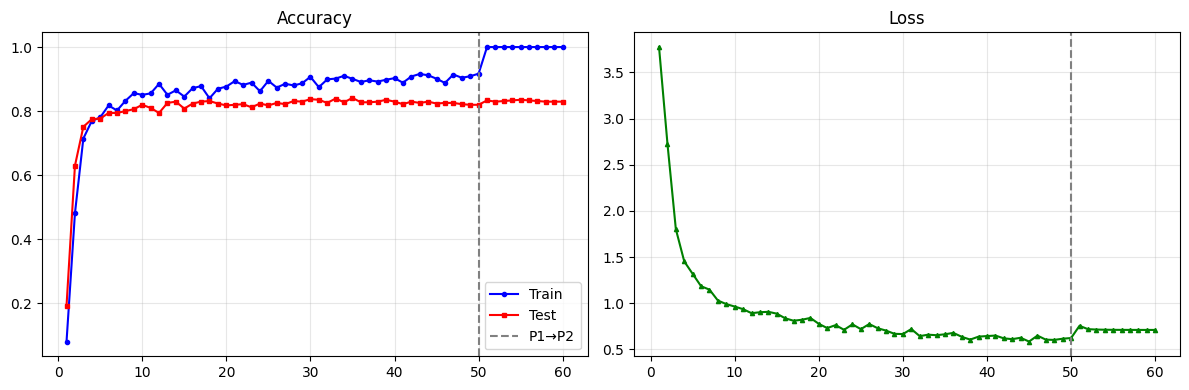

 epoch phase     loss  train_acc  test_acc  best_acc
     1    P1 3.773807   0.079955  0.192157  0.192157
     2    P1 2.729712   0.480534  0.629412  0.629412
     3    P1 1.802333   0.714286  0.750980  0.750980
     4    P1 1.453054   0.768983  0.774510  0.774510
     5    P1 1.318467   0.780084  0.776471  0.776471
     6    P1 1.184708   0.817568  0.794118  0.794118
     7    P1 1.147713   0.801802  0.794118  0.794118
     8    P1 1.029857   0.831885  0.800000  0.800000
     9    P1 0.991134   0.856017  0.805882  0.805882
    10    P1 0.964660   0.850708  0.819608  0.819608
    11    P1 0.936228   0.855212  0.809804  0.819608
    12    P1 0.893000   0.884974  0.794118  0.819608
    13    P1 0.903030   0.850869  0.825490  0.825490
    14    P1 0.907615   0.864865  0.829412  0.829412
    15    P1 0.887783   0.845238  0.807843  0.829412
    16    P1 0.837593   0.871622  0.823529  0.829412
    17    P1 0.811115   0.877896  0.829412  0.829412
    18    P1 0.822076   0.839929  0.831373  0.

In [13]:
if os.path.exists('history.csv'):
    df = pd.read_csv('history.csv')
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(df['epoch'], df['train_acc'], 'b-o', label='Train', ms=3)
    axes[0].plot(df['epoch'], df['test_acc'], 'r-s', label='Test', ms=3)
    axes[0].axvline(x=EPOCHS_P1, color='gray', ls='--', label='P1→P2')
    axes[0].set_title('Accuracy'); axes[0].legend(); axes[0].grid(alpha=0.3)
    axes[1].plot(df['epoch'], df['loss'], 'g-^', ms=3)
    axes[1].axvline(x=EPOCHS_P1, color='gray', ls='--')
    axes[1].set_title('Loss'); axes[1].grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('curves.png', dpi=150)
    plt.show()
    print(df.to_string(index=False))